## 1. Imports and Model Definition

In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from torch import nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()

        # Load pre-trained ResNeXt50 model and remove the last few layers
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])

        # Define an LSTM layer for sequence processing
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)
        x_lstm, _ = self.lstm(x)
        return fmap, self.dp(self.linear1(x_lstm[:, -1, :]))


## 2. Image Conversion and Prediction Functions

In [4]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1, 2, 0)
    image = np.clip(image, 0, 1)
    return image

def predict(model, img, path='./'):
    model.eval()  # Ensure the model is in evaluation mode
    fmap, logits = model(img.to('cpu'))
    weight_softmax = model.linear1.weight.detach().cpu().numpy()
    logits = sm(logits)
    _, prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100
    print('Confidence of prediction:', confidence)
    idx = np.argmax(logits.detach().cpu().numpy())
    bz, nc, h, w = fmap.shape
    out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h * w)).T, weight_softmax[idx, :].T)
    predict_img = out.reshape(h, w)
    predict_img = predict_img - np.min(predict_img)
    predict_img = predict_img / np.max(predict_img)
    predict_img = np.uint8(255 * predict_img)
    out = cv2.resize(predict_img, (im_size, im_size))
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    img = im_convert(img[:, -1, :, :, :])
    result = heatmap * 0.5 + img * 0.8 * 255
    cv2.imwrite(os.path.join(path, 'heatmap_result.png'), result)
    plt.imshow(result.astype(np.uint8))
    plt.show()
    return [int(prediction.item()), confidence]


## 3. Dataset Class and Video Processing

In [5]:
class ValidationDataset(Dataset):
    def __init__(self, video_names, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100 / self.sequence_length)
        first_frame = np.random.randint(0, a)
        for i, frame in enumerate(self.frame_extract(video_path)):
            faces = face_recognition.face_locations(frame)
            if faces:
                top, right, bottom, left = faces[0]
                frame = frame[top:bottom, left:right, :]
                frames.append(self.transform(frame))
                if len(frames) == self.sequence_length:
                    break
        frames = torch.stack(frames)
        frames = frames[:self.sequence_length]
        return frames.unsqueeze(0)

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = True
        while success:
            success, image = vidObj.read()
            if success:
                yield image


## 4. Data Transformation and Model Loading

In [8]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load video dataset and model
path_to_videos = ['fake.mp4']
video_dataset = ValidationDataset(path_to_videos, sequence_length=20, transform=train_transforms)
model = Model(num_classes=2).to('cpu')
path_to_model = 'model_84_acc_10_frames_final_data.pt'
model.load_state_dict(torch.load(path_to_model, map_location='cpu'))
model.eval()


C:\Users\sarat\AppData\Local\Temp\ipykernel_6000\2849050548.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_to_model, map_location

Model(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

## 5. Make Predictions

Processing video: fake.mp4
Confidence of prediction: 99.97151494026184


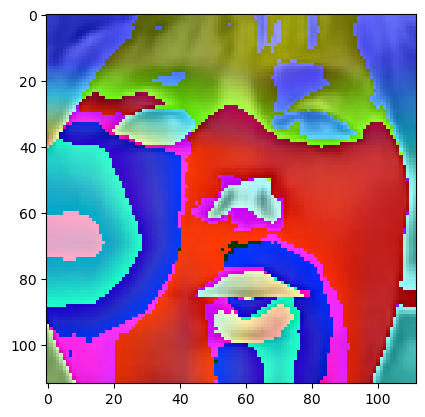

FAKE


In [9]:
for i in range(len(path_to_videos)):
    print(f"Processing video: {path_to_videos[i]}")
    prediction = predict(model, video_dataset[i], './')
    if prediction[0] == 1:
        print("REAL")
    else:
        print("FAKE")
